In [297]:
import numpy
import matplotlib.pyplot as plt


class Plant:

    def __init__(self, dt):

        self.x0 = 0.0
        self.x1 = 0.0
        self.dt = dt

        self.a0 = -1.5
        self.a1 = 1.0
        self.a2 = -0.2
        self.b  = 2.3

    def step(self, u):

        self.x0 = self.x0 + (self.a0*self.x0 + self.b*u)*self.dt
        self.x1 = self.x1 + (self.a1*self.x0 + self.a2*self.x1)*self.dt

        return self.x1

class PID:

    def __init__(self, kp, ki, kd, dt):
        self.kp = kp
        self.ki = ki
        self.kd = kd

        self.dt         = dt
        self.error_sum  = 0.0
        self.error_prev = 0.0


    def step(self, error):
        #requires 4 adds, 4 muls, 1div, fp32

        de = (error - self.error_prev)/self.dt
        self.error_prev = error

        self.error_sum+= error*self.dt

        u = self.kp*error + self.ki*self.error_sum + self.kd*de

        return u
    

class PIDDiscrete:

    def __init__(self, kp, ki, kd, dt, antiwindup):
        self.k0 = kp + ki*0.5*dt + kd/dt
        self.k1 = -kp + ki*0.5*dt -2.0*kd/dt
        self.k2 = kd/dt


        self.e0 = 0.0
        self.e1 = 0.0
        self.e2 = 0.0

        self.u  = 0.0
        self.antiwindup = antiwindup

        print(self.k0, self.k1, self.k2)
        

    def step(self, error):
        
        self.e2 = self.e1
        self.e1 = self.e0
        self.e0 = error

        #requires only 4 adds and 3 muls, int32
        self.u = self.u + self.k0*self.e0 + self.k1*self.e1 + self.k2*self.e2

        if self.u > self.antiwindup:
            self.u = self.antiwindup

        if self.u < -self.antiwindup:
            self.u = -self.antiwindup

        return self.u
    

class PIDDiscreteInt:

    '''
        kp : 16384 x Kp
        ki : 16384 x Ki
        kd : 16384 x Kd

        dt : step in ms, 1s = 1000
    '''
    def __init__(self, kp, ki, kd, dt, antiwindup):
        kp_ = kp
        ki_ = (ki*dt)/1000
        kd_ = (kd*1000)/dt

        self.k0 = int(kp_ + ki_ + kd_)
        self.k1 = int(-kp_ -2.0*kd_)
        self.k2 = int(kd_) 

        self.e0 = 0.0
        self.e1 = 0.0
        self.e2 = 0.0

        self.u  = 0.0
        self.antiwindup = antiwindup

        print(">>> ", self.k0, self.k1, self.k2)


      
    def step(self, error):
        
        self.e2 = self.e1
        self.e1 = self.e0
        self.e0 = error

        #requires only 4 adds and 3 muls, 1 shift, all int32
        self.u = self.u + (self.k0*self.e0 + self.k1*self.e1 + self.k2*self.e2)/16384

        if self.u > self.antiwindup:
            self.u = self.antiwindup

        if self.u < -self.antiwindup:
            self.u = -self.antiwindup

        return self.u



0.3834083333333333 -0.7165916666666666 0.3333333333333333
>>>  6282 -11741 5461


<Figure size 640x480 with 0 Axes>

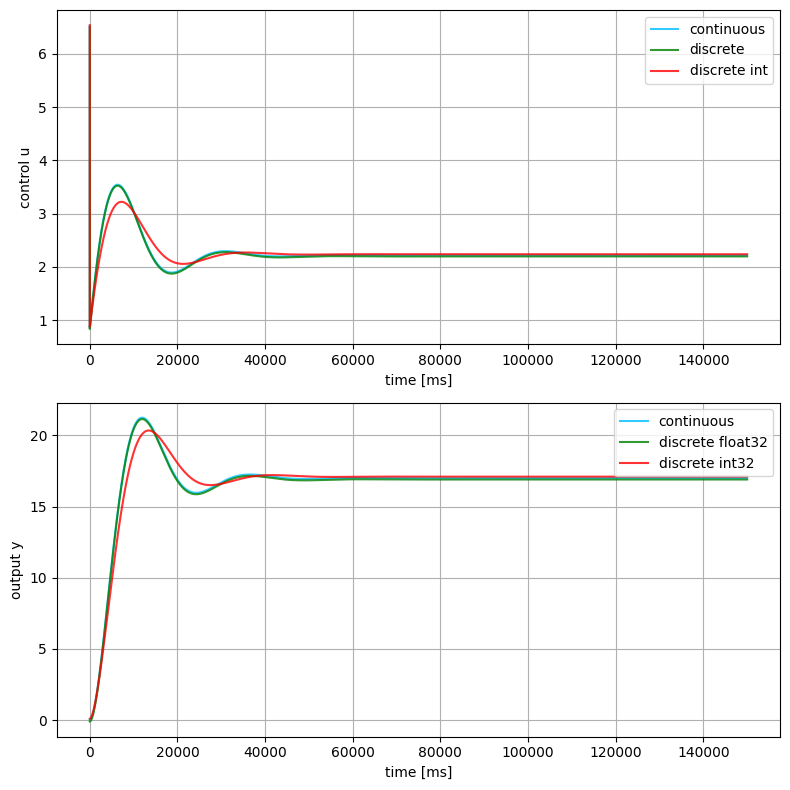

In [298]:
dt = 0.003
a  = -1.9
b  = 5.7

steps = 50000

y_req = 17



t_result        = []

plant_cont = Plant(dt)
u_cont = 0.0
u_cont_result   = []
y_cont_result   = []

plant_disc = Plant(dt)
u_disc = 0.0
u_disc_result   = []
y_disc_result   = []

plant_disc_int =Plant(dt)
u_disc_int = 0.0
u_disc_int_result   = []
y_disc_int_result   = []


kp = 0.05
ki = 0.05
kd = 0.001

antiwindup = 1000.0

pid_cont        = PID(kp, ki, kd, dt)
pid_disc        = PIDDiscrete(kp, ki, kd, dt, antiwindup)
pid_disc_int    = PIDDiscreteInt(kp*16384, ki*16384, kd*16384, dt*1000, antiwindup)

for i in range(steps):

    y_cont = plant_cont.step(u_cont)
    error = y_req - y_cont
    u_cont = pid_cont.step(error)

    y_disc = plant_disc.step(u_disc)
    error = y_req - y_disc
    u_disc = pid_disc.step(error)

    y_disc_int = plant_disc_int.step(u_disc_int)
    error = y_req - y_disc_int
    u_disc_int = pid_disc_int.step(error)



    t_result.append(i*dt)
    
    u_cont_result.append(u_cont)
    y_cont_result.append(y_cont)

    u_disc_result.append(u_disc - 0.02)
    y_disc_result.append(y_disc - 0.1)

    u_disc_int_result.append(u_disc_int + 0.02)
    y_disc_int_result.append(y_disc_int + 0.1)
    


t_result = numpy.array(t_result)*1000.0

plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(8, 8))


axs[0].plot(t_result, u_cont_result, label="continuous", color="deepskyblue", alpha=0.8)
axs[0].plot(t_result, u_disc_result, label="discrete", color="green", alpha=0.8)
axs[0].plot(t_result, u_disc_int_result, label="discrete int", color="red", alpha=0.8)
axs[0].set_xlabel("time [ms]")
axs[0].set_ylabel("control u")
axs[0].legend(loc='best')
axs[0].grid()

axs[1].plot(t_result, y_cont_result, label="continuous", color="deepskyblue", alpha=0.8)
axs[1].plot(t_result, y_disc_result, label="discrete float32", color="green", alpha=0.8)
axs[1].plot(t_result, y_disc_int_result, label="discrete int32", color="red", alpha=0.8)
axs[1].set_xlabel("time [ms]")
axs[1].set_ylabel("output y")
axs[1].legend(loc='best')
axs[1].grid()



plt.tight_layout()
plt.show()
#plt.savefig("pi_output.png", dpi = 300)